# Measure GRACE performance on identified objects:

All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [2]:
from grace.io.image_dataset import ImageGraphDataset
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.metrics_objects import (
    ExactMetricsComputer,
    ApproxMetricsComputer,
)

from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions,
    assume_dummy_predictions_from_annotations,
    add_and_remove_random_edges,
)
from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components,
)
from grace.evaluation.annotate import (
    draw_annotation_mask_from_ground_truth_graph,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# *EXACT* metrics on graph:

### Generate a random graph, update dummy labels & generate GT graph:

In [3]:
MOTIFS = ["line", "curve"]
N_MOTIFS = 2
DENSITY = 0.01

def generate_random_optimised_and_GT_graphs():
    G = random_graph(
        n_motifs=N_MOTIFS, 
        density=DENSITY, 
        motifs=MOTIFS
    )
    node_conf, edge_conf = 0.5, 0.1
    update_graph_with_dummy_predictions(
        G, 
        node_confidence=node_conf, 
        edge_confidence=edge_conf
    )
    # assume_annotations_from_dummy_predictions(G)
    true_graph = generate_ground_truth_graph(G)
    pred_graph = optimise_graph(G)

    return G, pred_graph, true_graph

### Keep making graphs until the prediction and GT come out different:

In [4]:
synthesize = True
counter = 0

while synthesize:
    counter += 1
    print (f"Synthesizing imperfectly optimised graph: iter = {counter}")

    G, pred_graph, true_graph = generate_random_optimised_and_GT_graphs()
    node_con = pred_graph.number_of_nodes() == true_graph.number_of_nodes()
    edge_con = pred_graph.number_of_edges() != true_graph.number_of_edges()
    
    if node_con and edge_con:
        synthesize = False


Synthesizing imperfectly optimised graph: iter = 1


### Visualise the resulting graphs:

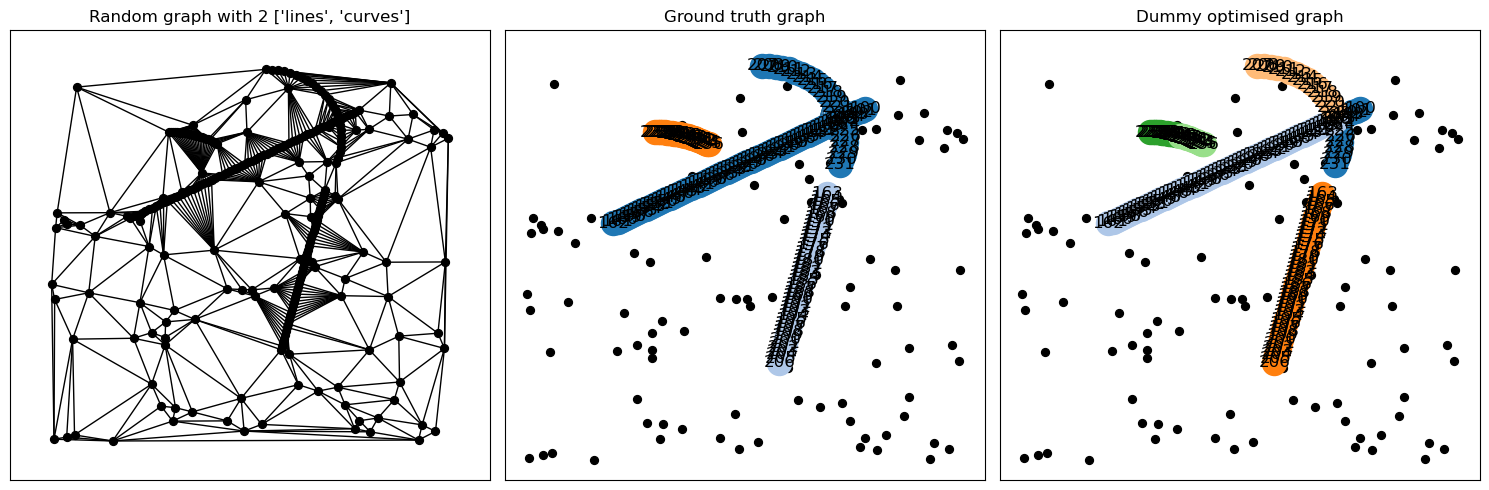

In [5]:
shape = 5
_, axes = plt.subplots(1, 3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Random graph with {N_MOTIFS} {MOTIFS}", ax=axes[0])
plot_connected_components(true_graph, title=f"Ground truth graph", ax=axes[1])
plot_connected_components(pred_graph, title=f"Dummy optimised graph", ax=axes[2])

plt.tight_layout()
plt.show()

## Evaluate the *exact* metrics on graphs:

In [6]:
EMC = ExactMetricsComputer(G=G, pred_optimised_graph=pred_graph, true_annotated_graph=true_graph)
results = EMC.metrics()
results

{'Accuracy (nodes)': 1.0,
 'Precision (nodes)': 1.0,
 'Recall (nodes)': 1.0,
 'F1-Score (nodes)': 1.0,
 'Accuracy (edges)': 0.993368700265252,
 'Precision (edges)': 1.0,
 'Recall (edges)': 0.9668874172185431,
 'F1-Score (edges)': 0.9831649831649832,
 'Semantic IoU': 1.0,
 'Instance IoU [mean]': 0.5,
 'Instance IoU [std]': 0.28356751786846573,
 'Instance IoU [list]': [0.18181818181818182,
  0.6477272727272727,
  1.0,
  0.17045454545454544,
  0.52,
  0.48]}

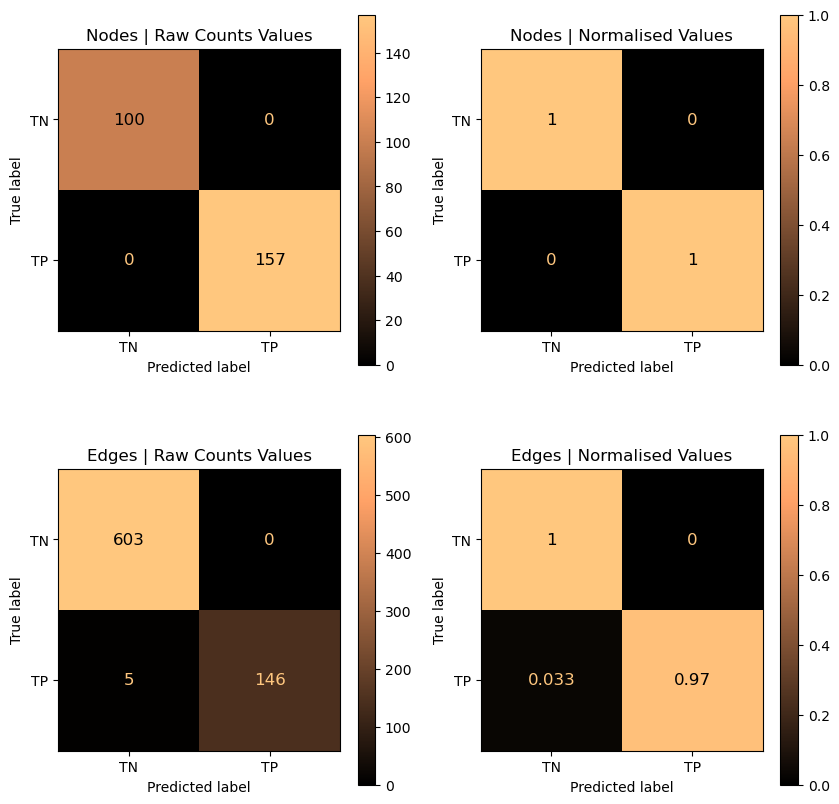

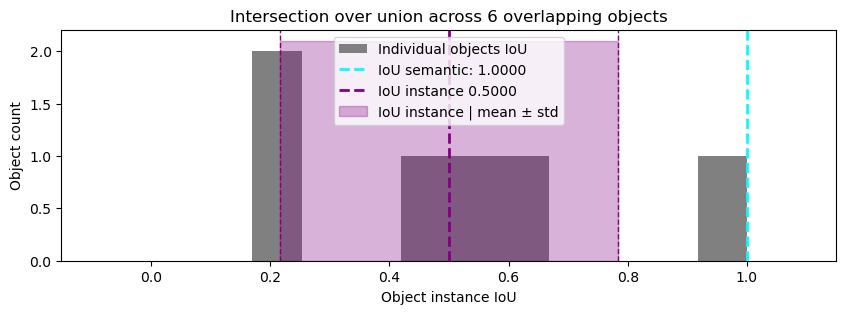

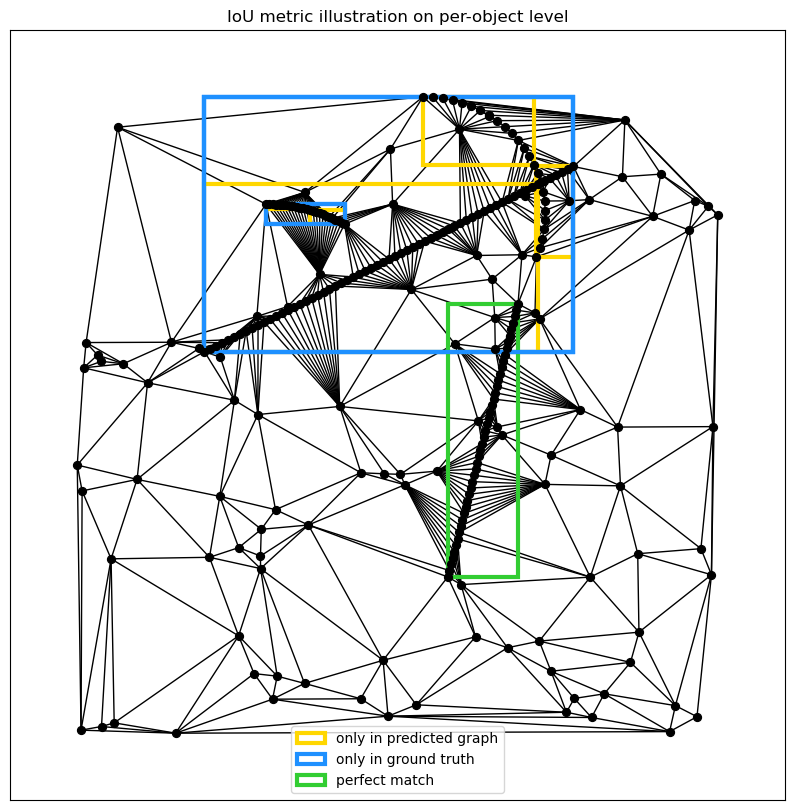

In [7]:
EMC.visualise()

# *Approx* metrics on annotation masks:

### Open an annotated image & visualise the annotation:

In [ ]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    keep_unknown_labels=False,
    verbose=True
)
image, graph_data = dataset[0]


### Prepare the GT graph & both hand- and auto-annotated masks:

In [ ]:
G = graph_data["graph"]
assume_dummy_predictions_from_annotations(G)

true_graph = generate_ground_truth_graph(G)
true_anno = graph_data["annotation"]

pred_graph = add_and_remove_random_edges(true_graph, G, 3, 5)
pred_anno = draw_annotation_mask_from_ground_truth_graph(
    pred_graph, 
    shape=image.shape, 
    brush_size=75
)

### Visualise together with the original image:

In [ ]:
def plot_image_with_masks(image_dict: dict[str, np.ndarray], figsize : tuple[int, int] = (15, 5)):
    _, axes = plt.subplots(1, len(image_dict), figsize=figsize)

    for i, (title, image) in enumerate(image_dict.items()):
        im = axes[i].imshow(image, cmap="binary_r")
        axes[i].set_title(title)
        plt.colorbar(im, ax=axes[i], fraction=0.045)
        
    plt.tight_layout()
    plt.show()


In [ ]:
image_dict = {
    "Original Image" : image,
    "Hand Annotated" : true_anno,
    "Auto Annotated" : pred_anno,
}
plot_image_with_masks(image_dict)

## Evaluate the *approx* metrics on masks:

In [ ]:
AMC = ApproxMetricsComputer(G, pred_anno, true_anno)
results = AMC.metrics()
results

In [ ]:
AMC.visualise()

### Done!